# INFO 2950 Project

Robin Ahn, Yama Bazger, Grace Myers, and Kaylah Nicholson (ordered alphabetically by last name)

**Phase 2** 





## Research Question
### Initial Research Questions:
Which country did k-pop have the most impact on? Where are a bulk of our tourists coming from, and which countries consume the most Korean content? 

### Refined Research Question:
 ###### “Multifaceted Impact Analysis of the K-pop Cultural Phenomenon on Global Tourist Demographics and Content Consumption Patterns with Respect to South Korea.”
We have a few deep-dive research questions to answer in order to obtain the fullest analogy possible:

**Part 1**: How does the consumption pattern of Korean content (especially K-pop) compare across different countries, particularly focusing on engagement metrics like likes, views, and comments?

- How do variations in these profiles signal different engagement or consumption patterns in K-pop-related tourism activities (or purposes in visitation, such as tourism)?

**Part 2**: How does the surge in the K-pop phenomenon correlate with trends in international visitor influx to South Korea across different countries and continents?

- How have political and global events (e.g., the COVID-19 pandemic, global K-pop events, and policy changes) intersected with these trends?
How do behavioral patterns among tourists (e.g., repeat visits, duration of stay, expenditure) illustrate the impact and immersion of K-pop culture in their travel experiences?


## Section 1: Datasets on Korean Tourism, Purpose of Visit, and Gender Identity of Visitors

Firstly, we will import all the relevant modules and libraries that will help us with our data analysis here.



In [62]:
import os
from datetime import datetime as dt 
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import duckdb
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

We will now import the CSV files that we will be processing.

In [3]:
current_path = os.getcwd() # This gets us the current path of this Jupyter file
korea_purpose = pd.read_csv(current_path + \
"/Korea_Visitors_By_Purpose-final.csv")
korea_gender = pd.read_csv(current_path + \
"/Korea_Visitors_By_Gender-final.csv")

def korea_events_reader(filename):
    current_path = os.getcwd()
    return current_path + "/" + filename
file_paths = ["Kpop events 2017.csv", "Kpop events 2018.csv", "Kpop events 2019.csv", 
              "Kpop events 2020.csv", "Kpop events 2021.csv", "Kpop events 2022.csv", 
              "Kpop events 2023.csv"]
events_2017 = pd.read_csv(korea_events_reader(file_paths[0]))
events_2018 = pd.read_csv(korea_events_reader(file_paths[1]))
events_2019 = pd.read_csv(korea_events_reader(file_paths[2]))
events_2020 = pd.read_csv(korea_events_reader(file_paths[3]))
events_2021 = pd.read_csv(korea_events_reader(file_paths[4]))
events_2022 = pd.read_csv(korea_events_reader(file_paths[5]))
events_2023 = pd.read_csv(korea_events_reader(file_paths[6]))

## Why was this dataset created?

The dataset was created as a foundation for amplification of the Korean tourism market. It also lays the framework for formulating future marketing strategies, thus allowing Korea to expand and tailor the tourism experience towards more targeted individuals. 

The dataset identifies the total number of visitors that came into South Korea from 2016- 2023. It also contains the purpose of visit(tourism, business, education, etc.), mode of transportation, gender, and whether the visitors were flight attendants or not (to differentiate from “real” visitors to flight attendants). 


## Who funded the creation of this dataset?

The Korean government has a separate entity called “Visit Korea Datalab” (by the Korean Tourism Organization) uber-focused on the research of Korean tourism. They funded the creation of the dataset by surveying visitors to Korea and integrating pre-existing datasets from “UNWTO World Tourism Barometer.” 

The datasets can be used freely under Korean Copyright Law if they are provided by the Korean Tourism Organization, and there is no need to provide any special form of acknowledgement as long as a link to one of its homepages (kto.visitkorea.or.kr) is provided.

The link to the Datalab itself is: https://datalab.visitkorea.or.kr/datalab/portal/main/getMainForm.do

## What processes might have influenced what data was observed and recorded and what was not?

From a social perspective, we believe occurrences of specific events such as K-pop concerts or fan meetups could have caused major spikes in the boost of visitors on certain dates, which might lead to a temporary skewing of our dataset. We plan to perform qualitative analysis to identify which major events took place and compare it with the data we grab from our dataset. 

From a data collection perspective, the survey design(what questions were asked, what order were they displayed in, and pre-written options) could have the biggest impact on what data was recorded. Another consideration would be who exactly was surveyed. We noticed this as we inspected that certain visitors were recorded as coming in from an “unidentified country,” as their citizenship was questionable. The timing of when they recorded the data could also have a big impact on showing results. In our case we decided to focus on a dataset that contained data before, during, and after the “k-pop boom” to properly identify the uptick in visitors and to identify which country was influenced the most by Korean culture. 


The original CSV files contained white spaces in some columns with string types. We will strip the white spaces for consistency and to have a more polished sets of data to work with.

In [4]:
#Stripping whitespaces for columns 'Continents', 'Country', and 'Purpose'
#for korea_purpose
korea_purpose['Continents'] = korea_purpose['Continents'].str.strip()
korea_purpose['Country'] = korea_purpose['Country'].str.strip()
korea_purpose['Purpose'] = korea_purpose['Purpose'].str.strip()

#Stripping whitespaces for columns 'Continents', 'Country', and 'Gender'
#for korea_gender
korea_gender['Continents'] = korea_gender['Continents'].str.strip()
korea_gender['Country'] = korea_gender['Country'].str.strip()
korea_gender['Gender'] = korea_gender['Gender'].str.strip()

We will check the initial shape of korea_purpose.

In [5]:
korea_purpose.shape

(37542, 7)

As we are working with multiple datasets (and later on, with a geo JSON file), we want to ensure some of the countries are named consistently across the datasets. The countries listed below were selected after the initial visual inspect of the CSV files on Google Sheets.

In [6]:
country_mapping = {
    'USA': 'United States of America',
    'UK': 'United Kingdom',
    'vietnam': 'Vietnam',
    'brazil': 'Brazil',
    'malaysia': 'Malaysia',
}

# Standardize country names in the 'korea_purpose' dataframe
korea_purpose['Country'] = \
korea_purpose['Country'].replace(country_mapping)

In [7]:
country_mapping_gender = {
    'USA': 'United States of America',
    'UK': 'United Kingdom',
    'vietnam': 'Vietnam',
    'Swiss': 'Switzerland',
    'malaysia': 'Malaysia',
    'Republic of South Africa': 'South Africa'
}

# Standardize country names in the 'korea_gender' dataframe
korea_gender['Country'] = \
korea_gender['Country'].replace(country_mapping_gender)

We will do some initially cleaning of the data, such as removing rows that contain terms "etc", "year", "Year and Continent", and "Korean" under "Country". Similarly, we do the same for the "Continent" column. The reason for this is because the original data was quite messy. For example, the term "year" under the column "Continent" does not really make any sense. 

Similarly, we excluded all the rows containing "Korean" as our focus is on foreign visitors to Korea, so Korean visitors (who may have dual citizenship or work abroad) are excluded from our analyses.

In [8]:
#Row removal for korea_purpose
# Define the conditions for each column using index locations
# Using index 1 for 'Continent'
condition_date = (korea_purpose.iloc[:, 0] == 'sum')  
condition_continent = korea_purpose.iloc[:, 1].isin\
(['Entire continent', 'year', 'Year and Continent', 'etc', 'Korean'])  
# Using index 2 for 'Country'
condition_country_name = korea_purpose.iloc[:, 2].isin\
(['Entire continent', 'year', 'Year and Continent', 'etc', 'Korean'])  
# Using index 3 for 'Purpose'
condition_purpose = korea_purpose.iloc[:, 3].isin(['entire'])

#Rows marked for deletion
rows_to_remove = \
korea_purpose[condition_date | condition_continent | \
condition_country_name | condition_purpose].index

#Now the actual deletion
korea_purpose = korea_purpose.drop(rows_to_remove)      

We do the same for korea_gender, except remove all the rows containing "sum", "Stewardess" and "entire". The original dataset for korea_gender contained "sum" rows in varying intervals where the sum of every few rows across columns were stated. 

Similarly, "Stewardess" was included as a term under "Gender", which is not relevant to our analyses. The term "entire" was present under "Gender", which was the summation of male, female, and visitors who were "Stewardess". Thus, we removed rows containing "entire" as well.

In [9]:
#Row removal for korea_gender
# Define the conditions for each column using index locations
# Using index 0 for 'Date'
condition_date = (korea_gender.iloc[:, 0] == 'sum')  
# Using index 1 for 'Continent'
condition_continent = korea_gender.iloc[:, 1].isin(['Entire continent', \
    'year', 'Year and Continent', 'etc', 'Korean']) 
# Using index 2 for 'Country'
condition_country_name = korea_gender.iloc[:, 2].isin(['Entire continent', 'year', \
    'Year and Continent', 'etc', 'Korean'])  
# Using index 3 for 'Purpose'
condition_purpose = korea_gender.iloc[:, 3].isin(['Stewardess', 'entire'])

#Rows marked for deletion
rows_to_remove = \
korea_gender[condition_date | condition_continent | \
condition_country_name | condition_purpose].index

#Now the actual deletion
korea_gender = korea_gender.drop(rows_to_remove)

In [10]:
def fix_south_korea(df):
    df['Country'] = df['Country'].str.replace(' ', '')  # Remove white spaces from the 'Country' column
    df['Country'] = df['Country'].str.replace('SouthKorea', 'South Korea', case=False)  # Replace 'SouthKorea' with 'South Korea' (case-insensitive)
    df['Country'] = df['Country'].str.replace(r'(?<!South)Korea', 'South Korea', case=False)  # Replace 'Korea' with 'South Korea' if not preceded by 'South' (case-insensitive)
    return df 
def rename_date(df):
    df.rename(columns={'Date(s)': 'Date'}, inplace=True)
    return df
events_list = [events_2017, events_2018, events_2019, events_2020, events_2021, events_2022, events_2023]
for i in range(len(events_list)):
    events_list[i] = rename_date(events_list[i])
for i in range(len(events_list)):
    events_list[i] = fix_south_korea(events_list[i])


In [11]:
def fix_dates(row):
    if row['Date'] in ['Mon', 'Tue', 'Wed', 'Thu', 'Thur', 'Fri', 'Sat', 'Sun']:
        return row['Artist / Guest']
    else:
        return row['Date']

# Applying the function to the Date(s) column
events_2017['Date'] = events_2017.apply(fix_dates, axis=1)

In [12]:
"""
This line of code checks for any dates where there is a range of Days given, like Sep 23-24 and fixes 
it by removing everything after the hyphen
"""
events_2017['Date'] = events_2017['Date'].apply(lambda x: x.split('-')[0] if '-' in x else x)

In [13]:
year = 2017
events_2017['Date'] = events_2017['Date'].apply(lambda x: x + f'-{year}' if '-' not in x else x + f'-{year}')

In [14]:
events_2017['Date'] = pd.to_datetime(events_2017['Date'], format='mixed')

In [15]:
events_2018['Date'] = events_2018['Date'].apply(lambda x: x.split('-')[0] if '-' in x else x)
year2 = 2018
events_2018['Date'] = events_2018['Date'].apply(lambda x: x + f'-{year2}' if '-' not in x else x + f'-{year2}')

In [16]:
events_2019['Date'] = events_2019['Date'].apply(lambda x: x.split('-')[0] if '-' in x else x)
year3 = 2019
events_2019['Date'] = events_2019['Date'].apply(lambda x: x + f'-{year3}' if '-' not in x else x + f'-{year3}')
events_2019['Date'] = pd.to_datetime(events_2019['Date'], format='mixed')

In [17]:
events_2020['Date'] = events_2020['Date'].apply(lambda x: x.split('-')[0] if '-' in x else x)
year4 = 2020
events_2020['Date'] = events_2020['Date'].apply(lambda x: x + f'-{year4}' if '-' not in x else x + f'-{year4}')
events_2020['Date'][29] = "Mar 01-2018" #Manually changed this one as the original value was formatted
#in an awkward way
events_2020['Date'] = pd.to_datetime(events_2020['Date'], format='mixed')


In [18]:
events_2021['Date'] = events_2021['Date'].apply(lambda x: x.split('-')[0] if '-' in x else x)
year5 = 2021
events_2021['Date'] = events_2021['Date'].apply(lambda x: x + f'-{year5}' if '-' not in x else x + f'-{year5}')
events_2021['Date'] = pd.to_datetime(events_2021['Date'], format='mixed')


In [19]:
events_2022['Date'] = events_2022['Date'].apply(lambda x: x.split('-')[0] if '-' in x else x)
year6 = 2022
events_2022['Date'] = events_2022['Date'].apply(lambda x: x + f'-{year6}' if '-' not in x else x + f'-{year6}')
mask = ~events_2022['Date'].str.contains('TBA-2022')
events_2022 = events_2022[mask]
events_2022['Date'][647] = 'Apr 15-2022'
events_2022['Date'] = pd.to_datetime(events_2022['Date'], format='mixed')

/var/folders/mk/v1928r054p7brpltxt8h4f6r0000gn/T/ipykernel_4765/3860524113.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_2022['Date'][647] = 'Apr 15-2022'
/var/folders/mk/v1928r054p7brpltxt8h4f6r0000gn/T/ipykernel_4765/3860524113.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_2022['Date'] = pd.to_datetime(events_2022['Date'], format='mixed')


In [20]:
events_2023['Date'] = events_2023['Date'].apply(lambda x: x.split('-')[0] if '-' in x else x)
year6 = 2023
events_2023['Date'] = events_2023['Date'].apply(lambda x: x + f'-{year6}' if '-' not in x else x + f'-{year6}')
mask2 = ~events_2023['Date'].str.contains('TBA-2023')
events_2023 = events_2023[mask2]
mask3 = ~events_2023['Date'].str.contains('Q4 2023-2023')
events_2023 = events_2023[mask3]
mask4 = ~events_2023['Date'].str.contains('Subconscious')
events_2023 = events_2023[mask4]
events_2023['Date'][23] = 'Dec 7-2023'
events_2023['Date'] = pd.to_datetime(events_2023['Date'], format='mixed')
#Deleting rows where the event has not happened yet
events_2023 = events_2023[events_2023['Date'] <= pd.to_datetime('2023-08-30')]

In [21]:
data_frames = [events_2017, events_2018, events_2019, events_2020, events_2021, events_2022, events_2023]
merged_df_events = pd.concat(data_frames, ignore_index=True)

In [22]:
merged_df_events = duckdb.sql("SELECT * FROM merged_df_events ORDER BY 'Date(s)'").df()
df_counts = merged_df_events.groupby(['Country', 'Date']).size().reset_index(name='Event Count')


/var/folders/mk/v1928r054p7brpltxt8h4f6r0000gn/T/ipykernel_4765/3087671312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_south_korea['Date'] = pd.to_datetime(df_south_korea['Date'], format='mixed')


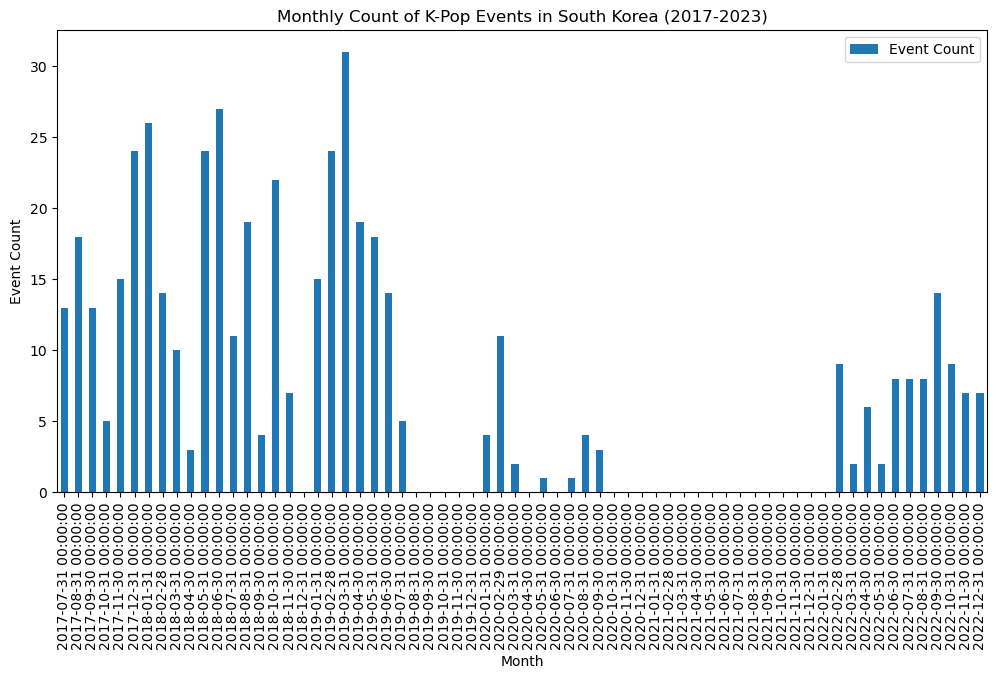

In [23]:
df_south_korea = df_counts[df_counts['Country'] == 'South Korea']
df_south_korea['Date'] = pd.to_datetime(df_south_korea['Date'], format='mixed')

# Set 'Date(s)' column as the index
df_south_korea = df_south_korea.set_index('Date')

# Resample data on a monthly basis and sum the event counts
df_south_korea_monthly = df_south_korea.resample('M').sum()

# Plotting the bar chart for monthly K-Pop events in South Korea
df_south_korea_monthly.plot(kind='bar', figsize=(12, 6))
plt.title('Monthly Count of K-Pop Events in South Korea (2017-2023)')
plt.xlabel('Month')
plt.ylabel('Event Count')
plt.show()

## Observations (rows) and Attributes (columns) for both data frames.

**Columns**: 
- **Date**: the date for every column value listed.
- **Visitors**: recorded every month from 2016-2023
- **Continent**: displayed in order of continent-country
- **Country**: countries that visited South Korea from 2016~2023. We excluded "hard to pinpoint" groupings such as GCC, Oceania, African countries(they simply had the continent name and didn't elaborate on which exact country within Africa)
- **Visitors Same Period Previous Year**: The number of visitors in the same period last year
- **Growth**: percentage increase in visitors from previous month
- **Purpose**: divided into commercial trips, official/governmental trips, tourism, education, etc. 
- **Gender**: only male and female. no third gender was recorded. 


**Rows**: country name, continent name, specific purpose of visit ('tourism', 'commercial, 'Public', 'Study Abroad', 'etc'), gender(male, female)


## What preprocessing was done?
- removed rows that refer to “Koreans living abroad” so we can only identify visitors of non-Korean ethnicities

- Data was originally written in Korean,  so we translated the information to English by converting it into a microsoft excel sheet and dropping it into google translate; sorting it into columns such as # of visitors to Korea, percentage increase of visitors, gender identity, etc. 


- We downloaded multiple datasets on the gender of visitors, the purpose of visitors, and the age of visitors from the same website. We decided to merge them while keeping overlapping information intact.

- We removed any rows that had the values “etc” or “miscellaneous” on the continent & country rows because they simply fogged up the dataset and we couldn’t figure out what countries/ continents they represented. 

- We also had rows that said “sum” as they stood for the total summation of all visitors from 2016-2023, which we deleted as it was not applicable and provided us with ridiculously high values. 

- We deleted entire rows if the column purpose contained the word “entire,” since it was too broad of a purpose and we wanted to identify the individual, accurate purpose of the visit.  


## If people are involved, were they aware of the data collection and if so, what purpose do they expect the data to be used for?

- We found a note on the dataset that mentioned Korea has been collecting tourism data from incoming foreign nationals since 1995. This shows it’s plausible that those working in the travel/leisure industry may be well-aware of said data collection efforts. Some of the data is derived from formal processes such as immigration and departures, where data collection is most likely expected and anticipated. 

- Incoming visitors to South Korea should expect the data to be used for obtaining general trends and insights into the Korean tourism industry. They can also expect the data to be utilized for economic analyses- as researchers attempt to observe the economic impacts and dependencies related to tourism. It could also be integrated into marketing and strategic planning to boost Korea’s appeal as a tourism destination. 


Now that we have deleted some. unknown number of rows, we will check the shape of korea_purpose to ensure the number of rows has decreased.

In [24]:
korea_purpose.shape

(24380, 7)

In korea_purpose, the Growth column had datapoints that contains "_". The underscore in the original dataset in Korean is actually a comma (e.g. "2_550.0" is really "2,550.0"). Either way, this inteferes with our data processing as we want the column data type to be a float. 

We found this issue when we were trying to generate random visualizations to ensure all the columns had the same type of values. 


In [25]:
korea_purpose['Growth'].dtype 

dtype('O')

Here, we will fix this by first changing every element under Growth to a string, and then, we will replace the underscore with a comma. 

In [26]:

# Replace underscores with a blank ""
korea_purpose['Growth'] = korea_purpose['Growth']\
.astype(str).str.replace('_', '')

# Convert the column back to float type
korea_purpose['Growth'] = korea_purpose['Growth']\
.astype(float)


To confirm the change has been made, we check the datatype of the Growth column again.

In [27]:
korea_purpose['Growth'].dtype

dtype('float64')

The "Date" column for both of the dataframes were not a datetime. We can observe this visually below and through using .dtype.

In [28]:
korea_gender.head()

,Date,Continents,Country,Gender,Visitors,Visitors Same Period Previous Year,Growth
0,201601,Oceania,Australia,male,5295,5402,-2.0
1,201601,Oceania,Australia,female,4414,4379,0.8
4,201602,Oceania,Australia,male,4239,3972,6.7
5,201602,Oceania,Australia,female,2807,2785,0.8
8,201603,Oceania,Australia,male,7022,5728,22.6


In [29]:
print(korea_gender['Date'].dtype)
print(korea_purpose['Date'].dtype)

int64
object


We change the date format for both dataframes to facilitate easier data processing 

In [30]:
korea_purpose['Date'] = pd.to_datetime(korea_purpose['Date'], \
                                       format='%Y%m')
korea_gender['Date'] = pd.to_datetime(korea_gender['Date'], \
                                      format='%Y%m')

Let's see if the conversion for both of the "Date" columns has happened to datetime.

In [31]:
print(korea_gender['Date'].dtype)
print(korea_purpose['Date'].dtype)

datetime64[ns]
datetime64[ns]


## Exhibit 1: Total Visitors by Gender
Graph of total visitors from every country, for any purpose(business/ tourism/ international relations, immigration, etc). 

Dates: 2016- 2023. 

Units: 10 million

Intention: We wanted to explore what gender is more inclined to visit Korea and learn the correlation of K-pop consumption habits and intent to tour the country. One caveat is that our YouTube consumption data doesn't exactly show the gender of the viewer. We're wondering how we can gather data that proves women are the primary consumer of K-pop content. 

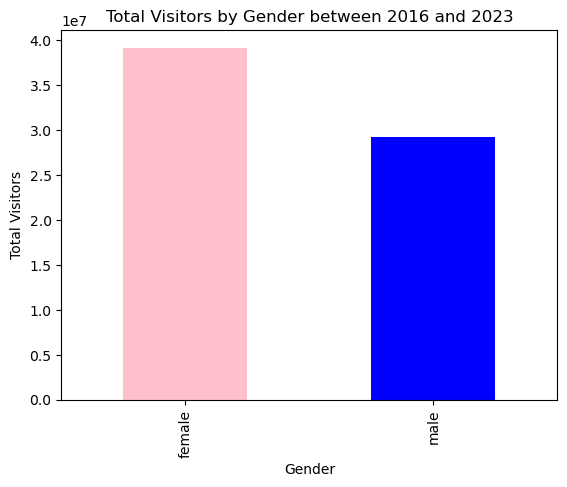

Gender
female    39186797
male      29267255
Name: Visitors, dtype: int64


In [32]:
total_visitors_by_gender = korea_gender.groupby('Gender')['Visitors'].sum()
# Create a bar plot
total_visitors_by_gender.plot(kind='bar', color=['pink', 'blue'])

# Add title and labels
plt.title('Total Visitors by Gender between 2016 and 2023')
plt.xlabel('Gender')
plt.ylabel('Total Visitors')

# Show the plot
plt.show()
print(total_visitors_by_gender)


## Exhibit 2: Total Visitors by Gender across Dates
Graph of total visitors from every country, for any purpose(commercial/tourism/educational/ etc)

Date: 2016-2023

Datasets cover 53 countries. 

Intention: In future submissions we plan to highlight which exact countries these visitors are from. We want to identify if it's 100% that women have a higher tendency to visit South Korea and identify what the biggest motiavtor behind that would be. Our current hypothesis is that it K-pop would be the biggest driving force behind Korea's tourism industry. One pitfall is that we don't have YouTube viewing data on China as a whole while our datasets show we're getting the most visitors from China. This limits us from performing an in-depth analysis on YouTube viewing habits and the correlation of K-pop-motivated tourism efforts.

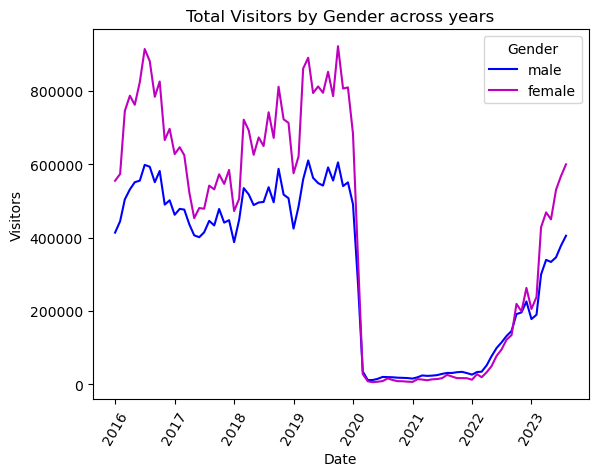

,Date,Continents,Country,Gender,Visitors,Visitors Same Period Previous Year,Growth
0,2016-01-01,Oceania,Australia,male,5295,5402,-2.0
1,2016-01-01,Oceania,Australia,female,4414,4379,0.8
4,2016-02-01,Oceania,Australia,male,4239,3972,6.7
5,2016-02-01,Oceania,Australia,female,2807,2785,0.8
8,2016-03-01,Oceania,Australia,male,7022,5728,22.6


In [58]:
total_visitors_by_gender = duckdb.sql("SELECT Date, Gender, \
SUM(Visitors) as Visitors FROM \
korea_gender GROUP BY Date, Gender").df()
sns.lineplot(
    data=total_visitors_by_gender, \
    x="Date", y="Visitors", hue="Gender", 
    palette= {"male": "b", "female": "m"})
plt.title('Total Visitors by Gender across years')
plt.xticks(rotation=60);

plt.show()

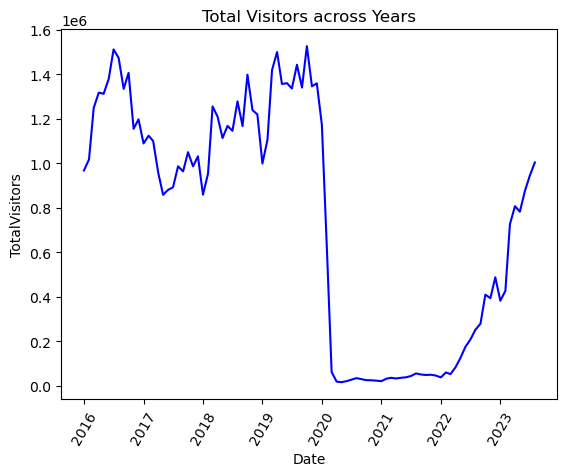

         Date  TotalVisitors
0  2016-01-01       968025.0
1  2016-02-01      1017513.0
2  2016-03-01      1249204.0
3  2016-04-01      1317745.0
4  2016-05-01      1312501.0
..        ...            ...
87 2023-04-01       807459.0
88 2023-05-01       782816.0
89 2023-06-01       876390.0
90 2023-07-01       944439.0
91 2023-08-01      1004228.0

[92 rows x 2 columns]


In [50]:
total_visitors_across_time = duckdb.sql("SELECT Date, \
    SUM(Visitors) as TotalVisitors FROM \
    korea_gender GROUP BY Date").df()

# Assuming 'Date' is in datetime format
sns.lineplot(data=total_visitors_across_time, x="Date", y="TotalVisitors", color="blue")
plt.title('Total Visitors across Years')
plt.xticks(rotation=60)
plt.show()

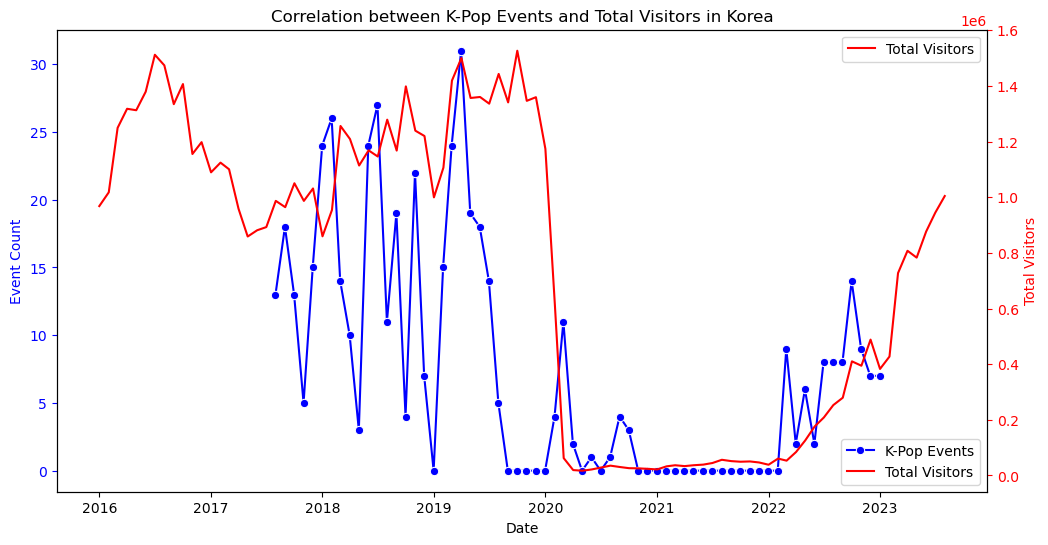

In [47]:
# Merge the two DataFrames on the 'Date' column
merged_df2 = pd.merge(df_south_korea_monthly, total_visitors_across_time, on='Date', how='outer')

# Plotting the line plot for K-pop events and total visitors
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the K-pop events data on the left y-axis with dots
sns.lineplot(data=merged_df2, x='Date', y='Event Count', ax=ax1, label='K-Pop Events', color='blue', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Event Count', color='blue')
ax1.tick_params('y', colors='blue')

# Creating a secondary y-axis for the total visitors data on the right
ax2 = ax1.twinx()
sns.lineplot(data=merged_df2, x='Date', y='TotalVisitors', ax=ax2, label='Total Visitors', color='red')
ax2.set_ylabel('Total Visitors', color='red')
ax2.tick_params('y', colors='red')
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles + handles2, labels + labels2, loc='lower right')

plt.title('Correlation between K-Pop Events and Total Visitors in Korea')
plt.show()

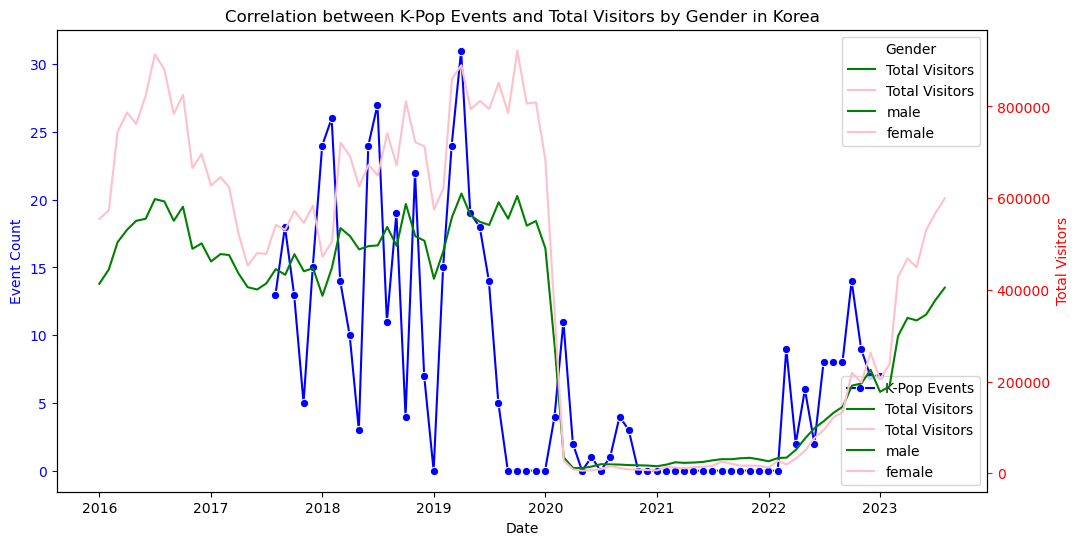

In [66]:
# Merge the two DataFrames on the 'Date' column
merged_df3 = pd.merge(df_south_korea_monthly, total_visitors_by_gender, on='Date', how='outer')

# Plotting the line plot for K-pop events and total visitors
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the K-pop events data on the left y-axis with dots
sns.lineplot(data=merged_df3, x='Date', y='Event Count', ax=ax1, label='K-Pop Events', color='blue', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Event Count', color='blue')
ax1.tick_params('y', colors='blue')

# Creating a secondary y-axis for the total visitors data on the right
ax2 = ax1.twinx()
sns.lineplot(data=merged_df3, x='Date', y='Visitors', ax=ax2, label='Total Visitors', color='red', hue='Gender', palette = {"female": "pink", "male": "green"})
ax2.set_ylabel('Total Visitors', color='red')
ax2.tick_params('y', colors='red')
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles + handles2, labels + labels2, loc='lower right')

plt.title('Correlation between K-Pop Events and Total Visitors by Gender in Korea')
plt.show()

In [64]:
merged_df3['Date'] = pd.to_datetime(merged_df3['Date']).dt.strftime('%Y-%m')

# Handling missing values
merged_df3.fillna({'Event Count': 0, 'Visitors': 0}, inplace=True)
# Step 2: Encoding Categorical Variables
# If Gender is a categorical variable, use one-hot encoding
encoder = OneHotEncoder()
gender_encoded = encoder.fit_transform(merged_df3[['Gender']]).toarray()
# Use get_feature_names_out for newer versions of scikit-learn
gender_df = pd.DataFrame(gender_encoded, columns=encoder.get_feature_names_out(['Gender']))
merged_df3_encoded = pd.concat([merged_df3, gender_df], axis=1)

# Step 3: Building the Regression Model
# Defining the independent variables (X) and the dependent variable (Y)
X = merged_df3_encoded[['Event Count', 'Gender_female', 'Gender_male']]
Y = merged_df3_encoded['Visitors']

# Adding a constant to the model (for intercept)
X = sm.add_constant(X)

# Step 4: Training the Model
model = sm.OLS(Y, X).fit()

# Step 5: Evaluating the Model
# You can split the data into training and testing sets to evaluate the model

# Step 6: Interpreting the Results
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:               Visitors   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     42.93
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           2.40e-22
Time:                        20:37:53   Log-Likelihood:                -3447.1
No. Observations:                 250   AIC:                             6902.
Df Residuals:                     246   BIC:                             6916.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.733e-10   3.87e+04  -1.48e-14

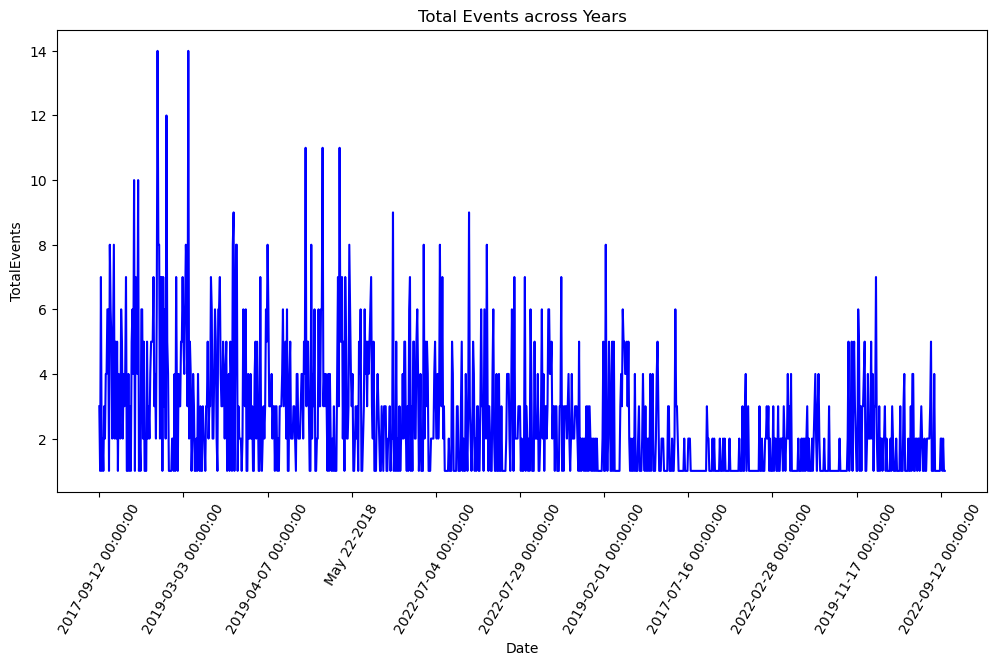

In [36]:
query = """
SELECT Date, SUM("Event Count") as TotalEvents
FROM df_counts
GROUP BY Date
"""
total_events_across_time = duckdb.query(query).df()

# Plotting the line plot for total events
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(data=total_events_across_time, x="Date", y="TotalEvents", color="blue", ax=ax)
ax.set_title('Total Events across Years')
ax.set_xticks(ax.get_xticks()[::int(len(total_events_across_time['Date']) / 10)])  # Adjust the interval as needed
ax.set_xticklabels(total_events_across_time['Date'][::int(len(total_events_across_time['Date']) / 10)], rotation=60)

plt.show()

In [37]:
duplicate_df = total_events_across_time.copy()

# Convert 'Date' column in the duplicate DataFrame
duplicate_df['Date'] = pd.to_datetime(duplicate_df['Date'], errors='coerce')

# Find invalid dates in the duplicate DataFrame
invalid_dates = duplicate_df[duplicate_df['Date'].isna()]

print("Invalid dates in duplicate_df:")
for index, row in invalid_dates.iterrows():
    print(f"Index: {index}, Date: {row['Date']}")

# Use the index locations from the duplicate DataFrame to print the dates from the original DataFrame
print("\nDates from the original DataFrame:")
for index in invalid_dates.index:
    original_date = total_events_across_time.loc[index, 'Date']
    print(f"Index: {index}, Original Date: {original_date}")
total_invalid_dates = len(invalid_dates)
print(f"\nTotal number of invalid dates: {total_invalid_dates}")

Invalid dates in duplicate_df:
Index: 3, Date: NaT
Index: 4, Date: NaT
Index: 5, Date: NaT
Index: 6, Date: NaT
Index: 34, Date: NaT
Index: 35, Date: NaT
Index: 36, Date: NaT
Index: 37, Date: NaT
Index: 38, Date: NaT
Index: 39, Date: NaT
Index: 40, Date: NaT
Index: 41, Date: NaT
Index: 42, Date: NaT
Index: 43, Date: NaT
Index: 44, Date: NaT
Index: 45, Date: NaT
Index: 54, Date: NaT
Index: 79, Date: NaT
Index: 80, Date: NaT
Index: 81, Date: NaT
Index: 82, Date: NaT
Index: 83, Date: NaT
Index: 84, Date: NaT
Index: 86, Date: NaT
Index: 87, Date: NaT
Index: 162, Date: NaT
Index: 163, Date: NaT
Index: 164, Date: NaT
Index: 165, Date: NaT
Index: 166, Date: NaT
Index: 167, Date: NaT
Index: 168, Date: NaT
Index: 169, Date: NaT
Index: 170, Date: NaT
Index: 171, Date: NaT
Index: 172, Date: NaT
Index: 173, Date: NaT
Index: 174, Date: NaT
Index: 175, Date: NaT
Index: 182, Date: NaT
Index: 183, Date: NaT
Index: 184, Date: NaT
Index: 186, Date: NaT
Index: 200, Date: NaT
Index: 201, Date: NaT
Index: 2

In [38]:
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, errors='raise')
    except:
        # Handle custom parsing for specific formats
        if 'Aug' in date_str:
            # Handle 'Aug 08-2018' format
            parts = date_str.split(' ')
            return pd.to_datetime(f'{parts[1]}-{parts[0]}', errors='raise')
        elif 'Jul' in date_str:
            # Handle 'Jul 15-2018' format
            parts = date_str.split(' ')
            return pd.to_datetime(f'{parts[1]}-{parts[0]}', errors='raise')
        # Add more custom parsing for other formats if needed
        else:
            return pd.NaT  # Return NaT for unknown formats

# Apply the parsing function to the 'Date' column of the original DataFrame
total_events_across_time['Date'] = total_events_across_time['Date'].apply(parse_date)

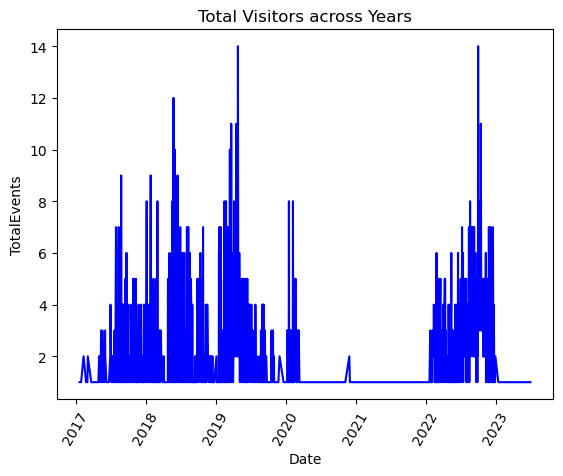

In [39]:
sns.lineplot(data=total_events_across_time, x="Date", y="TotalEvents", color="blue")
plt.title('Total Visitors across Years')
plt.xticks(rotation=60)
plt.show()

In [40]:
print(total_events_across_time['Date'].dtype)
#total_events_by_month = total_events_across_time.groupby(total_events_across_time['Date'].dt.month).sum()
total_events_across_time['Month'] = total_events_across_time['Date'].dt.to_period('M')
#total_events_across_time['Month'] = total_events_across_time['Month'].astype('int')
#total_events_by_month = duckdb.sql("SELECT Month, SUM(TotalEvents) as TotalSum FROM total_events_across_time GROUP BY Month").df()
print(total_events_across_time)


datetime64[ns]
           Date  TotalEvents    Month
0    2017-09-12          3.0  2017-09
1    2017-10-04          1.0  2017-10
2    2022-12-02          7.0  2022-12
3    2018-08-08          1.0  2018-08
4    2018-07-15          2.0  2018-07
...         ...          ...      ...
1041 2020-02-01          2.0  2020-02
1042 2017-09-11          1.0  2017-09
1043 2018-12-09          2.0  2018-12
1044 2022-01-25          1.0  2022-01
1045 2019-06-20          1.0  2019-06

[1046 rows x 3 columns]


## Exhibit 3: Total Visitors by Country- Top 5

Graph of Korea's top 5 visitors

Date: 2016-2023

We have surprisingly observed that while Korean content consumption peaked during COVID, the # of visitors didn't surge as much after COVID ended. Another interesting observation is that Korea has had a gigantic influence on "Chinese" countries such as China, Hong Kong, and Taiwan. For phase 3, we plan to group the China-based countries together to open up 2 more spaces of other countries and analyze what non-Asian countries have been affected the most. 
- We also believe the USA contains too many ethnicities of people and feel limited that we can't perform an extra set of analyses to determine which ethnicity of Americans have been affected by K-pop so much to visit Korea.

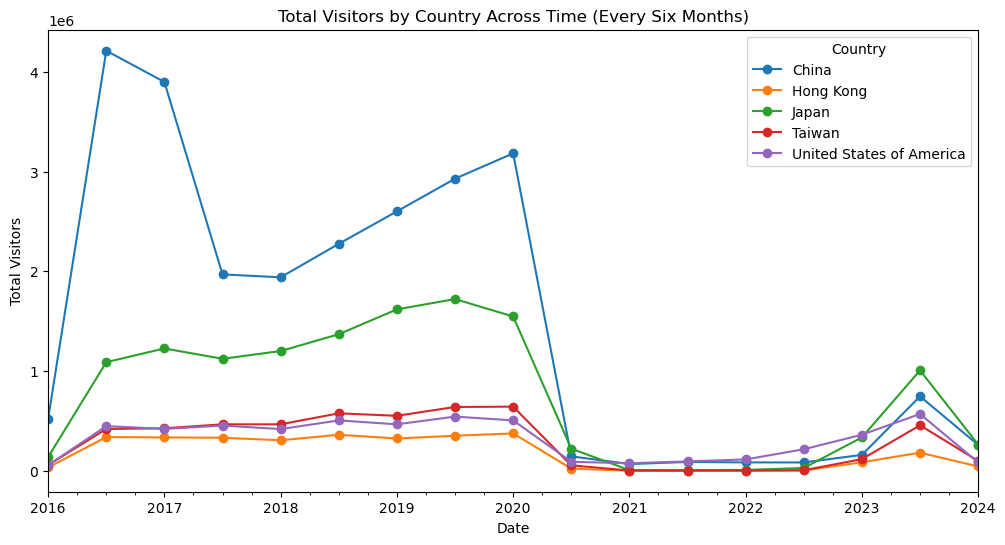

In [41]:
total_visitors_country = korea_purpose.groupby('Country')['Visitors'].sum()

# Select top 5 countries
top_5_countries = total_visitors_country.nlargest(5).index

# Filter the data for the top 5 countries
df_top_5 = korea_purpose[korea_purpose['Country'].isin(top_5_countries)]

# Group the data by 'Country' and 'Date' with six-month intervals 
#and calculate the total visitors for each group
total_visitors_country_time = df_top_5.groupby(['\
Country', pd.Grouper(key='Date', freq='6M')])['Visitors'].sum().\
unstack(level=0)

# Plot the data
ax = total_visitors_country_time.plot(kind='line', marker='o', 
    figsize=(12, 6))

# Add title and labels
plt.title('Total Visitors by Country Across Time (Every Six Months)')
plt.xlabel('Date')
plt.ylabel('Total Visitors')

# Show the plot
plt.show()

## Exhibit 3.5: A map of countries with the most visitors to Korea

Mapped visualization of all visitors to South Korea.

Date: 2016-2023

The description for Exhibit 3 can apply here. This exhibit is included solely to enhance the visualization of the visitors to Korea.

/Users/yamabazger/anaconda3/envs/info2950/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


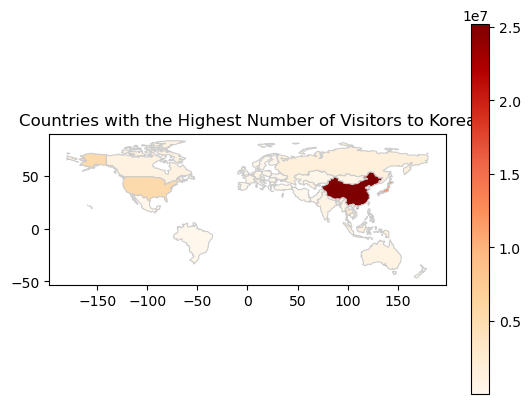

In [42]:
# Read the world map data using geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


# Merge the world map with your dataframes
merged_data = world.merge(korea_purpose, left_on='name', right_on='Country')

# Calculate the total visitors for each country
country_visitors = merged_data.groupby('name')['Visitors'].sum().\
reset_index()

# Merge the visitor data with the world map data
final_map_data = world.merge(country_visitors, left_on='name', 
                             right_on='name')

# Create the map
fig, ax = plt.subplots(1, 1)
final_map_data.plot(column='Visitors', cmap='OrRd', linewidth=0.8, ax=ax, 
                    edgecolor='0.8', legend=True)
ax.set_title('Countries with the Highest Number of Visitors to Korea')

# Show the plot
plt.show()

## Exhibit 4: Total Visitors by Country with a focus on Tourism 

In this graph, we have looked into what countries visit Korea the most with the intent to TOUR. Before this graph we were looking at total number of visitors for any purpose, including business/ international affairs/ immigration/ tourism.

It appears that Japan has suddenly come on top after COVID, ranking #1 for tourism. This opens up the window for us to investigate if Japan's k-pop consumption habits have risen simultaneously during this period, thus motivating Japanese nationals to visit South Korea. There are other factors to take into account here though, such as looking into whether China and Korea's relationship has worsened, thus restricting Chinese travel to South Korea. 

Date: 2016-2023


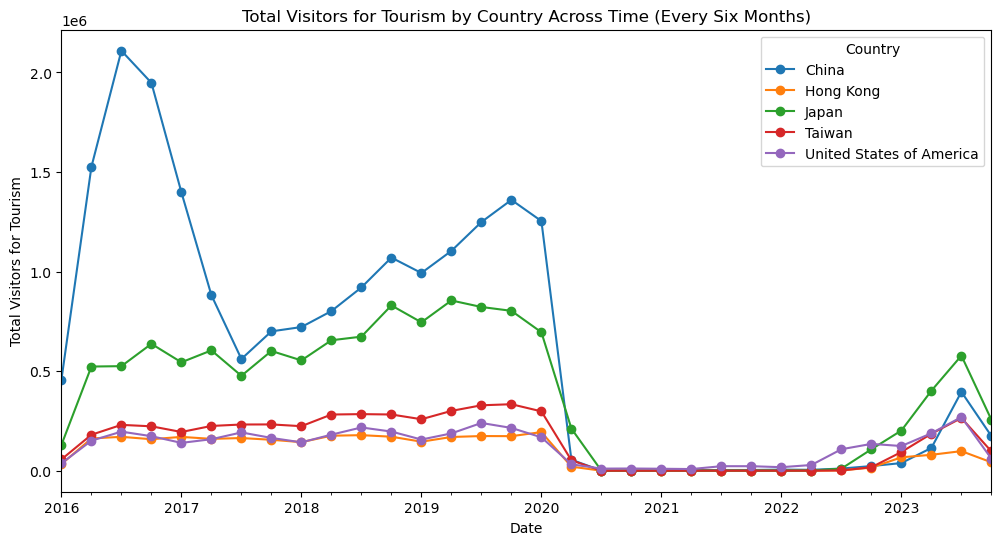

In [43]:
# Filter the data for the purpose of 'tourism'
korea_purpose_tourism = korea_purpose[korea_purpose['Purpose'] == 'tourism']

# Sum up the total visitors for each country with the purpose of tourism
total_visitors_country_tourism = \
korea_purpose_tourism.groupby('Country')['Visitors'].sum()

# Select top 5 countries
top_5_countries_tourism = total_visitors_country_tourism.nlargest(5).index

# Filter the data for the top 5 countries
korea_purpose_top_5_tourism = \
korea_purpose_tourism[korea_purpose_tourism['Country'].\
                                                    \
                      isin(top_5_countries_tourism)]

# Group the data by 'Country' and 'Date' with six-month intervals and 
#calculate the total visitors for each group
total_visitors_country_time_tourism = korea_purpose_top_5_tourism.\
groupby(['Country', \
         pd.Grouper(key='Date', \
                    freq='3M')])['Visitors'].sum().unstack(level=0)

# Plot the data
ax = total_visitors_country_time_tourism.plot(kind='line', marker='o', \
                                              figsize=(12, 6))

# Add title and labels
plt.title('Total Visitors for Tourism by Country Across Time (Every Six Months)')
plt.xlabel('Date')
plt.ylabel('Total Visitors for Tourism')

# Show the plot
plt.show()

## Exhibit 5: Total Visitors for tourism by gender 

Added with the intent to discover the correlation between k-pop consumption, gender, and tourism. 

We plan to delete this dataset as we can't figure out why we're getting the same exact number of male and female visitors for each year.

## Q for TAs: Could you look into our code to pinpoint what is causing this error? We've even experimented with ChatGPT and still can't figure it out. Thank you so very much!

Date: 2016-2023 

In [44]:
# Filter the data for the purpose of 'tourism'
merged_df_tourism = merged_df[merged_df['Purpose'] == 'tourism']

# Compute total visitors for tourism by gender and country
total_visitors_tourism_gender_country = merged_df_tourism.\
groupby(['Country', 'Gender'])['Visitors_x'].sum().unstack()

# Select top 5 countries based on total visitors for tourism
top_5_countries_tourism = \
total_visitors_tourism_gender_country.sum(axis=1).nlargest(5).index

# Filter the data for the top 5 countries
total_visitors_tourism_gender_country_top5 = \
total_visitors_tourism_gender_country.loc[top_5_countries_tourism]

# Plot the data
total_visitors_tourism_gender_country_top5.plot(kind='bar', \
                        figsize=(10, 6),color=['pink', 'blue'])
plt.title('Total Visitors for Tourism by Gender for Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Total Visitors for Tourism')
plt.show()

NameError: name 'merged_df' is not defined

## Exhibit 6: Total Visitors by gender with an emphasis on dates

Added with the intent to discover at which point in time global visitation to Korea has spiked, and to see the correlation between the timing of these spikes and the rise of K-pop content consumption. 

Date: 2016-2023

An interesting observation is that during the COVID pandemic, the number of male visitors is significantly higher than female visitors. We are wondering if this is worth taking a look at. 

We plan to do this by:
- Determining the main "purpose of travel" these male visitors had for their trip to Korea
- Identifying whether their trips were primarily motavited by "tourism"(which may mean K-pop fandom activities) or "business/ international relations."

If they were mostly in Korea for tourism, it could suggest the male global fanbase for K-pop has been growing during COVID, or that men were more willing to actively travel to Korea during the pandemic. 

We could further investigate to see if there were any K-pop events or marketing campaigns released at that time that specifically targeted male audiences, leading to this spike in male visitors.

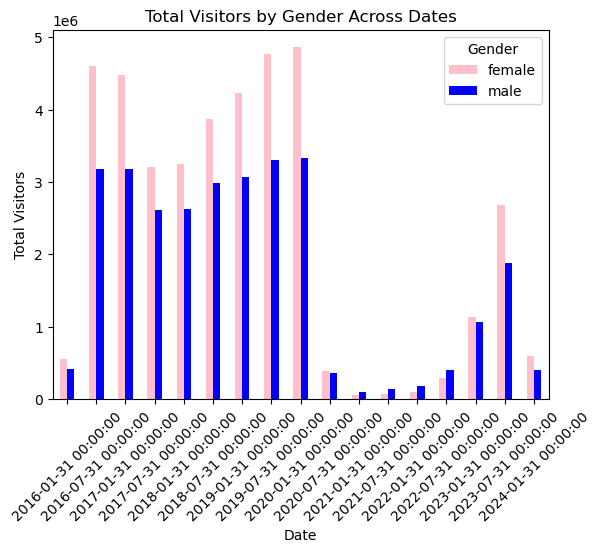

In [45]:
total_visitors_date_gender = \
korea_gender.groupby(['Date', \
    'Gender'])['Visitors'].sum().unstack()


total_visitors_date_gender = total_visitors_date_gender.resample('6M').sum()
# Plot the data
total_visitors_date_gender.plot(kind='bar', color=['pink', 'blue'])

# Add title and labels
plt.title('Total Visitors by Gender Across Dates')
plt.xlabel('Date')
plt.ylabel('Total Visitors')
plt.xticks(rotation=45)
# Show the plot
plt.show()

## Data limitations- any potential problems with these datasets (On Korean Tourism)
- Not all countries were covered by these datasets, especially those in Africa. They were simply labelled as "etc" or "misc" (depends on the translation) in some instances. This could be because the number of visitors from the missing countries were relatively low, thus they have been defocused from the datasets.
- Given that certain categories of data have been excluded during our cleanup process, there could be a sampling bias that omits certain traveler profiles or travel purposes. The generalizability of the dataset might be hindered.

- The specificity and granularity of "purpose of visit" could still bring up challenges. If travelers have multiple purposes (e.g., business and tourism), it might not be accurately reflected.

- Since we dumped the dataset into some kind of “google spreadsheets translate” software, cultural and linguistic nuances might be lost, which might impact the accuracy of categorical and textual data, especially regarding country names or purpose classifications.

- Gender is only identified as either male or female. Ensuring that gender classifications are accurate and respectful of visitor self-identification, and navigating potential cultural differences in gender classifications, could be important.
- There is room for further processing that is missing at this time. For example, the difference between GCC in the geo JSON file and the two dataframes. The former explicitly states the countries (e.g. Saudi Arabia, Qatar, and so on) while the latter two collectively labels them as GCC. This has led to the GCC countries to be entirely missing from the map.


## Section 2: Datasets on YouTube Content Consumption with a focus on K-pop

This section focuses on how the consumption pattern of Korean content (especially K-pop) compares across different countries, particularly focusing on engagement metrics like likes, views, and comments. 

Our raw data can be found at https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset/data.

Here, we will select the relevant columns of the data, and add a column to represent the respective country. The resulting dataframe is returned.

In [ ]:
def add_column(abbrv, country):
    '''
    Param abbrv: string of the file's abbreviation
    Param country: string of the country's name
    '''
    df = pd.read_csv(current_path + "/" +abbrv+'_youtube_trending_data.csv') 
    country_df = duckdb.sql("SELECT publishedAt, \
                       trending_date, tags, view_count, likes, \
                       comment_count \
                       FROM df \
                       WHERE CONTAINS(tags, 'k-pop')").df()
    country_df.insert(0, 'country', country) 
    return country_df

## Why was this dataset created?

The dataset was created to organize the top trending videos on Youtube each day, as an updated version of the Youtube Trending Video Statistics and Comments dataset. It is a daily record of the top trending videos, which Youtube identifies through a combination of factors including a measure of user interactions (e.g. likes, views, comments).


## Who funded the creation of this dataset?

This license for this dataset CC0: Public Domain and is publicly funded, with 54 total unique contributors. It was created using https://youtube.com’s API.

## What processes might have influenced what data was observed and recorded and what was not?

Culturally, highly anticipated videos like music releases will draw in more interaction like views and likes. Specifically in the kpop community, there is often a goal to surpass previously trending videos and have the highest possible view count for a new music video. So, we believe there will be observed and recorded increases within the first few days of publishing followed by a declining pattern. Since this dataset was created from the measurable information of a public domain, the way it’s recorded is unlikely to be subjective, however there may be a difference in terms of a cutoff in the number of trending videos.

We combined the abbreviated columns as well as the columns with the full country name to make processing easier.

In [ ]:
brazil_df = add_column('BR', 'Brazil')
brazil_df

In [ ]:
canada_df = add_column('CA', 'Canada')
canada_df

In [ ]:
denmark_df = add_column('DE', 'Denmark')
denmark_df

In [ ]:
france_df = add_column('FR', 'France')
france_df

In [ ]:
india_df = add_column('IN', 'India')
india_df

In [ ]:
japan_df = add_column('JP', 'Japan')
japan_df

In [ ]:
mexico_df = add_column('MX', 'Mexico')
mexico_df

In [ ]:
russia_df = add_column('RU', 'Russia')
russia_df

In [ ]:
united_states_df = add_column('US', 'US')
united_states_df

In [ ]:
united_kingdom_df = add_column('GB', 'UK')
united_kingdom_df

Once all individual country columns are combined, we will make another combined dataframe of all of the given countries.

In [ ]:
combined_df = duckdb.sql("SELECT * FROM brazil_df \
                            UNION ALL \
                            SELECT * FROM canada_df \
                            UNION ALL \
                            SELECT * FROM denmark_df \
                            UNION ALL \
                            SELECT * FROM france_df \
                            UNION ALL \
                            SELECT * FROM united_kingdom_df \
                            UNION ALL \
                            SELECT * FROM india_df \
                            UNION ALL \
                            SELECT * FROM japan_df \
                            UNION ALL \
                            SELECT * FROM mexico_df \
                            UNION ALL \
                            SELECT * FROM russia_df \
                            UNION ALL \
                            SELECT * FROM united_states_df").df()
combined_df

## Observations (rows) and Attributes (columns)

**Attributes**:

- *country*: The name of the country in which the Youtube video was published.
- *publishedAt*: The date of when the Youtube video was published.
- *trending_date*: The date of when the Youtube video was observed as trending.
- *tags*: The specific descriptor tag or tags the Youtube video was published under.
- *view_count*: A measure of how many views the Youtube video amassed since being published.
- *likes*: A measure of how many likes the Youtube video amassed since being published.
- *comment_count*:  A measure of how many comments were linked to the Youtube video since being published

**Observations**:

Each row represents the information described in each column for a distinct Youtube video.

## What preprocessing was done?

- We removed the columns of video_id, channel_id, category_id as they were not readable identifiers.
- We then removed the columns: thumbnail_link, comments_diabled, ratings_disabled, and description because they all returned FALSE
- The dislikes column was removed because more recent videos were coming up as having no dislikes, but this may have been because YT changed their dislike model (previously you could see dislikes, but now only the number of likes can be seen). Instead, we used likes, views, and comments to gage video popularity.
- Lastly, we sorted the tags column by “k-pop” because entertainment companies were easier to objectively list in terms of popularity compared to k-beauty influencers.

## If people are involved, were they aware of the data collection and if so, what purpose do they expect the data to be used for?

While all of Youtube’s users might not have directly known they were involved in this data collection, their agreement to Youtube’s Terms and Conditions means they consented to their interactive information (i.e. likes, views, and comments) as well as their profile demographics (i.e. country of origin) being stored by Youtube and used in this dataset.

Next, we will then create multiple pie charts of the data which analyze each category per country.

In [ ]:
def create_piechart(df, column):
    '''
    Param df: Pandas dataframe
    Param column: String of the column in df to be analyzed

    '''
    grouped = combined_df.groupby('country')[column].sum()
    plt.pie(grouped,labels=grouped.index,autopct='%.2f%%')
    plt.show()

## Exhibit 1: Total view count per country
Pie chart of the total number of views on kpop Youtube videos per country, represented by percentages, in order to visualize which countries most heavily participated in the trending of certain Youtube videos in regards to views.

Date: 2020-2023

Intention: To discover what countries are the most involved in viewing kpop Youtube videos and if it correlates to the country of origin of tourists in Korea. We also want to further develop our question regarding bots that may automatically watch or interact with the video, what countries they originate from, and how it affects our data. Looking at our visualizations at a glance, certain countries, like Mexico, have high percentages in online participation and interaction, but little to no data as a country of origin for tourists. We believe this to be the case because people from those countries might not have the funds to travel to Korea, while Chinese citizens would have a better chance since they are neighboring countries.

In [ ]:
create_piechart(combined_df, 'view_count')

## Exhibit 2: Total number of likes per country
Pie chart of the total like count on kpop Youtube videos per country, represented by percentages, in order to visualize which countries most heavily participated in the trending of certain Youtube videos in regards to likes.

Date: 2020-2023

Intention: To discover what country is the most involved in interacting with kpop Youtube videos and if it correlates to the country of origin of tourists in Korea. We also want to compare the number of likes and comments, to see how people like to interect with Youtube videos and if that means anything.
- Liking a video could represent the stance of an observer who enjoys kpop, but might not have an opinion on traveling to Korea.

In [ ]:
create_piechart(combined_df, 'likes')

## Exhibit 3: Total comment count per country
Pie chart of the total number of comments on kpop Youtube videos per country, represented by percentages, in order to visualize which countries most heavily participated in the trending of certain Youtube videos in regards to comments.

Date: 2020-2023

Intention: To discover what countries are the most involved in commenting on kpop Youtube videos and if it correlates to the country of origin of tourists in Korea. We also want to compare the number of likes and comments, to see how people like to interect with Youtube videos and if that means anything.
- Commenting on a video could represent some form of deeper or parasocial relationship, that would cause them to visit Korea.

In [ ]:
create_piechart(combined_df, 'comment_count')

## Exhibit 4: Total view count over time
A graph of the total view count on kpop Youtube videos over the time period of 2020-2023.

Date: 2020-2023

Intention: We hope to understand the larger spike in the data, what caused it, and if it has to do with our query on Youtube bots. We also want to discover patterns within the views of trending Youtube videos, and if those patterns correlate to any patterns in tourism over time.

In [ ]:
combined_df['publishedAt'] = pd.to_datetime(combined_df['publishedAt'])
country_views = \
combined_df.groupby('country')['view_count'].sum().reset_index()
top_countries = country_views.nlargest(5, 'view_count')
selected_rows = \
combined_df[combined_df['country'].isin(top_countries['country'])]
plt.figure(figsize=(12, 6))
sns.lineplot(data=selected_rows, x='publishedAt',
             y='view_count', hue='country', palette='bright')

plt.xlabel('Time Published')
plt.ylabel('Views')
plt.title('Kpop Youtube Views Over Time for Top 5 Countries')
plt.xticks(rotation=45)
plt.legend(title='Country', loc='upper left')

plt.show()


## Exhibit 5: Total like count over time
A graph of the total like count on kpop Youtube videos over the time period of 2020-2023.

Date: 2020-2023

Intention: We want to discover patterns within the number of likes of trending Youtube videos to see if those patterns correlate to any patterns in tourism over time. For example, if an increase in video interection means an increase in tourism for each 6 month period that we visualized in the previous section.

In [ ]:
combined_df['publishedAt'] = pd.to_datetime(combined_df['publishedAt'])
country_likes = combined_df.groupby('country')['likes'].sum().reset_index()
top_countries = country_likes.nlargest(5, 'likes')
selected_rows = \
combined_df[combined_df['country'].isin(top_countries['country'])]
plt.figure(figsize=(12, 6))
sns.lineplot(data=selected_rows, x='publishedAt',
             y='likes', hue='country', palette='bright')
plt.xlabel('Time Video Published')
plt.ylabel('Comments')
plt.title('Kpop Youtube Likes Over Time for Top 5 Countries')
plt.xticks(rotation=45)
plt.legend(title='Country', loc='upper left')
plt.show()


## Exhibit 6: Total comment count over time
A graph of the total comment count on kpop Youtube videos over the time period of 2020-2023.

Date: 2020-2023

Intention: Just as with the likes and views, we want to discover patterns within the number of comments of trending Youtube videos, and if those patterns correlate to any patterns in tourism over time.

In [ ]:
combined_df['publishedAt'] = pd.to_datetime(combined_df['publishedAt'])
country_comments = \
combined_df.groupby('country')['comment_count'].sum().reset_index()
top_countries = country_comments.nlargest(5, 'comment_count')
selected_rows = \
combined_df[combined_df['country'].isin(top_countries['country'])]
plt.figure(figsize=(12, 6))
sns.lineplot(data=selected_rows, x='publishedAt',
             y='comment_count', hue='country', palette='bright')
plt.xlabel('Time Video Published')
plt.ylabel('Comments')
plt.title('Kpop Youtube Comments Over Time for Top 5 Countries')
plt.xticks(rotation=45)
plt.legend(title='Country', loc='upper left')
plt.show()




## Data limitations- any potential problems with these datasets (On Trending Youtube Videos)
- One crucial country that is missing from the YouTube datasets is China. This can be explained as other local alternatives to YouTube is used in China. We may potentially factor in the alternatives in the near future.

- The dislikes feature and how it’s information was displayed was changed by Youtube in a fairly recent update, so the dataset contains inconsistent measurements in that aspect which can’t be compared fully. 
- The dataset also categorized the trending videos for certain countries (Brazil, Canada, Germany, France, United Kingdom, India, Japan, Korea, Mexico, Russia, and the United States), but doesn’t take into account all other countries with Youtube users, so the summarization of trending videos is incomplete. 
- And while the Youtube data Japan includes Japanese groups, depending on how they are marketed or if they fall under Korean entertainment companies might muddy the data. 
- The likes and comments for videos are relatively similar in the way they present themselves, but there’s a large spike in views and then a decline, which could indicate a change in the way Youtube displays or tracks views.
- There are "Bots" everywhere that have been bought to distort the views of k-pop videos. This might affect the genuity of the data.

## Questions for reviewers

- Are our research questions too expansive? How do you suggest we narrow it down?
- How might we visualize/ explore the impact of K-pop across multiple nations and ethnicities?
- Any other methods of data cleaning you suggest we implement other than what we’ve already done, to narrow down and refine the quality of our data?
- Is 2 datasets enough, or do you suggest we add more?
- Any other suggestions on what more we could explore with our current datasets? What findings can we extract? What more questions should we ask?